In [155]:
from zgulde.ds_imports import *
import acquire

canada, mexico = acquire.get_data()
canada

,port_name,state,port_code,border,date,crossing_method,n_crossings
0,Alexandria Bay,NY,708,US-Canada Border,2019-12-01,Bus Passengers,740
1,Baudette,MN,3424,US-Canada Border,2019-12-01,Bus Passengers,83
2,Blaine,WA,3004,US-Canada Border,2019-12-01,Bus Passengers,17029
4,Buffalo-Niagara Falls,NY,901,US-Canada Border,2019-12-01,Bus Passengers,9910
5,Calais,ME,115,US-Canada Border,2019-12-01,Bus Passengers,279
...,...,...,...,...,...,...,...
353956,Point Roberts,WA,3017,US-Canada Border,1996-01-01,Rail Containers Empty,0
353957,Antler,ND,3413,US-Canada Border,1996-01-01,Personal Vehicle Passengers,1576
353959,Calais,ME,115,US-Canada Border,1996-01-01,Trucks,8955
353960,Carbury,ND,3421,US-Canada Border,1996-01-01,Truck Containers Empty,0


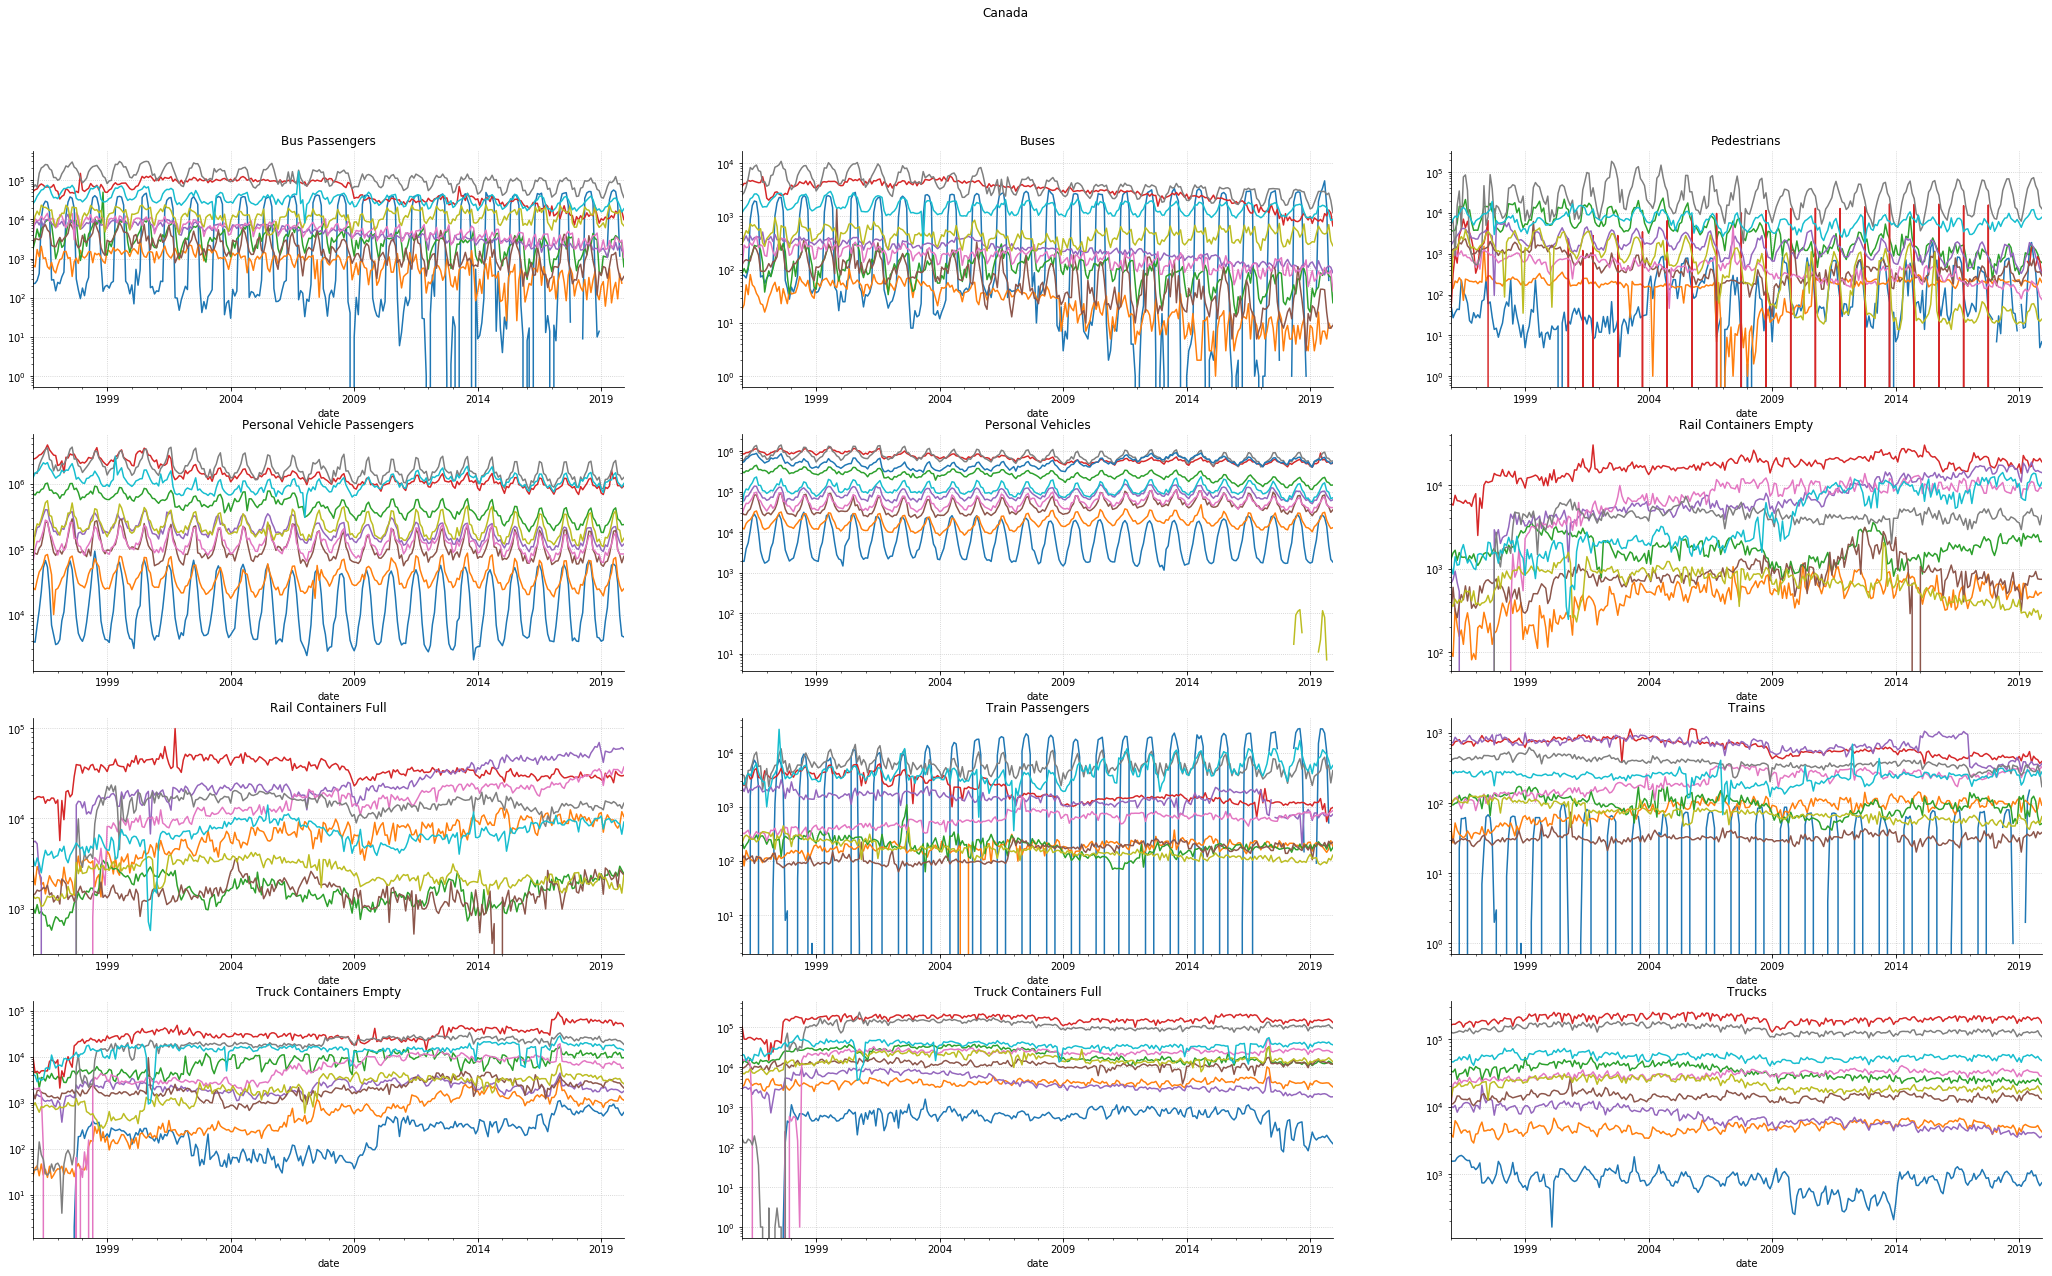

In [46]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Canada')

for ax, (method, data) in zip(axs.ravel(), canada.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'state', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
    ax.set_yscale('log')

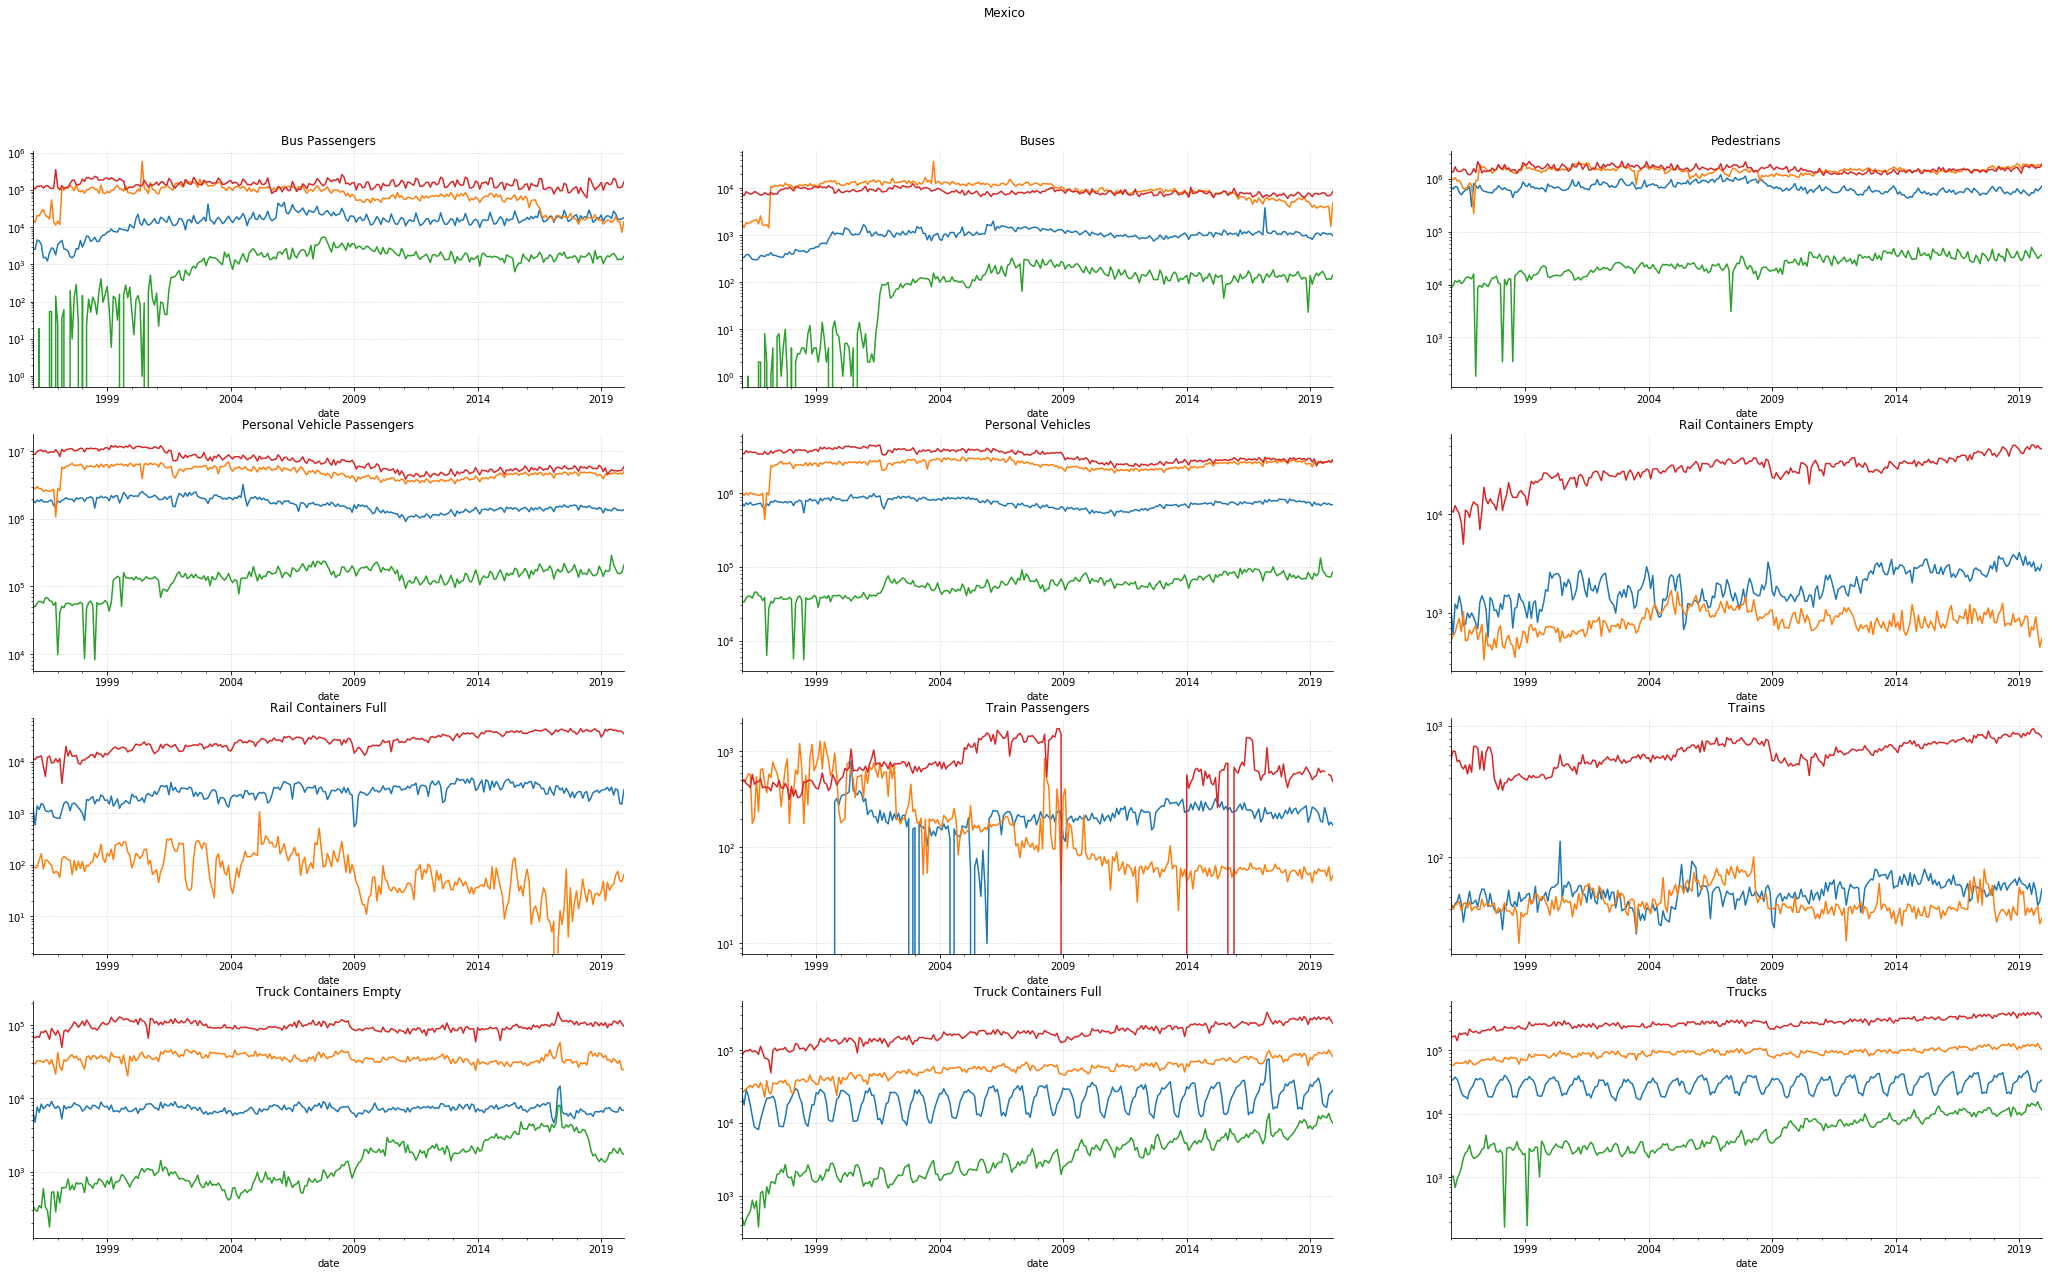

In [47]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Mexico')

for ax, (method, data) in zip(axs.ravel(), mexico.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'state', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
    ax.set_yscale('log')

In [156]:
mexico.head()

,port_name,state,port_code,border,date,crossing_method,n_crossings
3,Brownsville,TX,2301,US-Mexico Border,2019-12-01,Bus Passengers,4668
6,Calexico East,CA,2507,US-Mexico Border,2019-12-01,Bus Passengers,4080
8,Columbus,NM,2406,US-Mexico Border,2019-12-01,Bus Passengers,1452
11,Douglas,AZ,2601,US-Mexico Border,2019-12-01,Bus Passengers,107
13,Eagle Pass,TX,2303,US-Mexico Border,2019-12-01,Bus Passengers,8525


Focus on Laredo Pedestrians

In [164]:
laredo = mexico[((mexico.port_name == 'Laredo') & 
                 (mexico.crossing_method == 'Pedestrians'))][['date','n_crossings']]

# laredo = mexico[mexico.port_name == 'Laredo'][['date','crossing_method','n_crossings']]

,n_crossings
date,
2013-01-01,284996
2013-02-01,266783
2013-03-01,325008
2013-04-01,296050
2013-05-01,300737


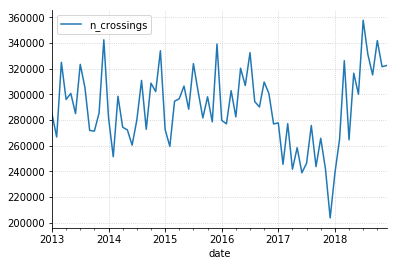

In [174]:
laredo.head()
# pandas needs you to sort the date before setting the index
train = laredo.sort_values('date').rename(columns = {'date': 'ds', 'n_crossings': 'y'}).\
set_index('ds')[:'2018']
test = laredo.sort_values('date').set_index('date')['2019':]
train = train['2013':]
train.plot()

# set baseline model predicting 2019 using the mean
train.mean()

train.head()

n_crossings    289447.430556
dtype: float64

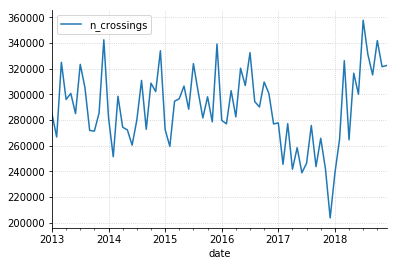

In [173]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()
    

1. Average over last 5 years
2. get the data into the shape we want
2. standardize
3. kmeans
4. add clusters back to original data

In [62]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [63]:
def min_max_scale_col(col: pd.Series) -> pd.Series:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(col.values.reshape(-1,1))
    return pd.Series(scaled[:, 0], index=col.index)


mex_ports = (mexico
             .set_index('date')
             .sort_index()['2015':'2018']
             .pivot_table(values = 'n_crossings', index = 'port_name', columns = 'crossing_method', aggfunc = 'median')
             .fillna(0)
             .apply(min_max_scale_col)
            )

# scaler = MinMaxScaler(copy=True, feature_range=(0,1))
# mex_ports = pd.DataFrame(scaler.fit_transform(mex_ports), 
#                         columns = mex_ports.columns.values
#                         ).set_index([mex_ports.index.values])

ca_ports = (canada
             .set_index('date')
             .sort_index()['2015':'2018']
             .pivot_table(values = 'n_crossings', index = 'port_name', columns = 'crossing_method', aggfunc = 'median')
             .fillna(0)
             .apply(min_max_scale_col)
            )

# ca_ports = pd.DataFrame(scaler.fit_transform(ca_ports), 
#                                 columns = ca_ports.columns.values
#                               ).set_index([ca_ports.index.values])

In [64]:
mex_ports.head()

crossing_method,Bus Passengers,Buses,Pedestrians,Personal Vehicle Passengers,Personal Vehicles,Rail Containers Empty,Rail Containers Full,Train Passengers,Trains,Truck Containers Empty,Truck Containers Full,Trucks
port_name,,,,,,,,,,,,
Andrade,0.000000,0.000000,0.099969,0.044933,0.039411,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Boquillas,0.000000,0.000000,0.001427,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Brownsville,0.054125,0.166716,0.339522,0.387070,0.332531,0.424941,0.039520,0.000000,0.20121,0.159834,0.088667,0.104748
Calexico,0.000000,0.000000,0.543730,0.319508,0.309432,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Calexico East,0.136956,0.069416,0.029898,0.275167,0.263091,0.038662,0.001078,0.034286,0.06354,0.309028,0.126049,0.165992


Text(0, 0.5, 'Intertia')

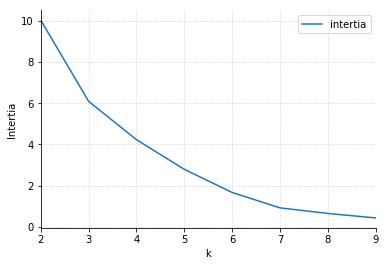

In [65]:
data = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k).fit(mex_ports)
    data.append({'k': k, 'intertia': kmeans.inertia_})

pd.DataFrame(data).set_index('k').plot()
plt.ylabel('Intertia') #inertia is the sum of the squared distances from each point to its cluster center. 

kmeans = KMeans(n_clusters=2, random_state=123).fit(mex_ports)
mex_clusters = pd.Series(kmeans.predict(mex_ports), index=mex_ports.index, name='port_cluster')

mexico = mexico.set_index('port_name').join(mex_clusters).reset_index()
mexico.head()

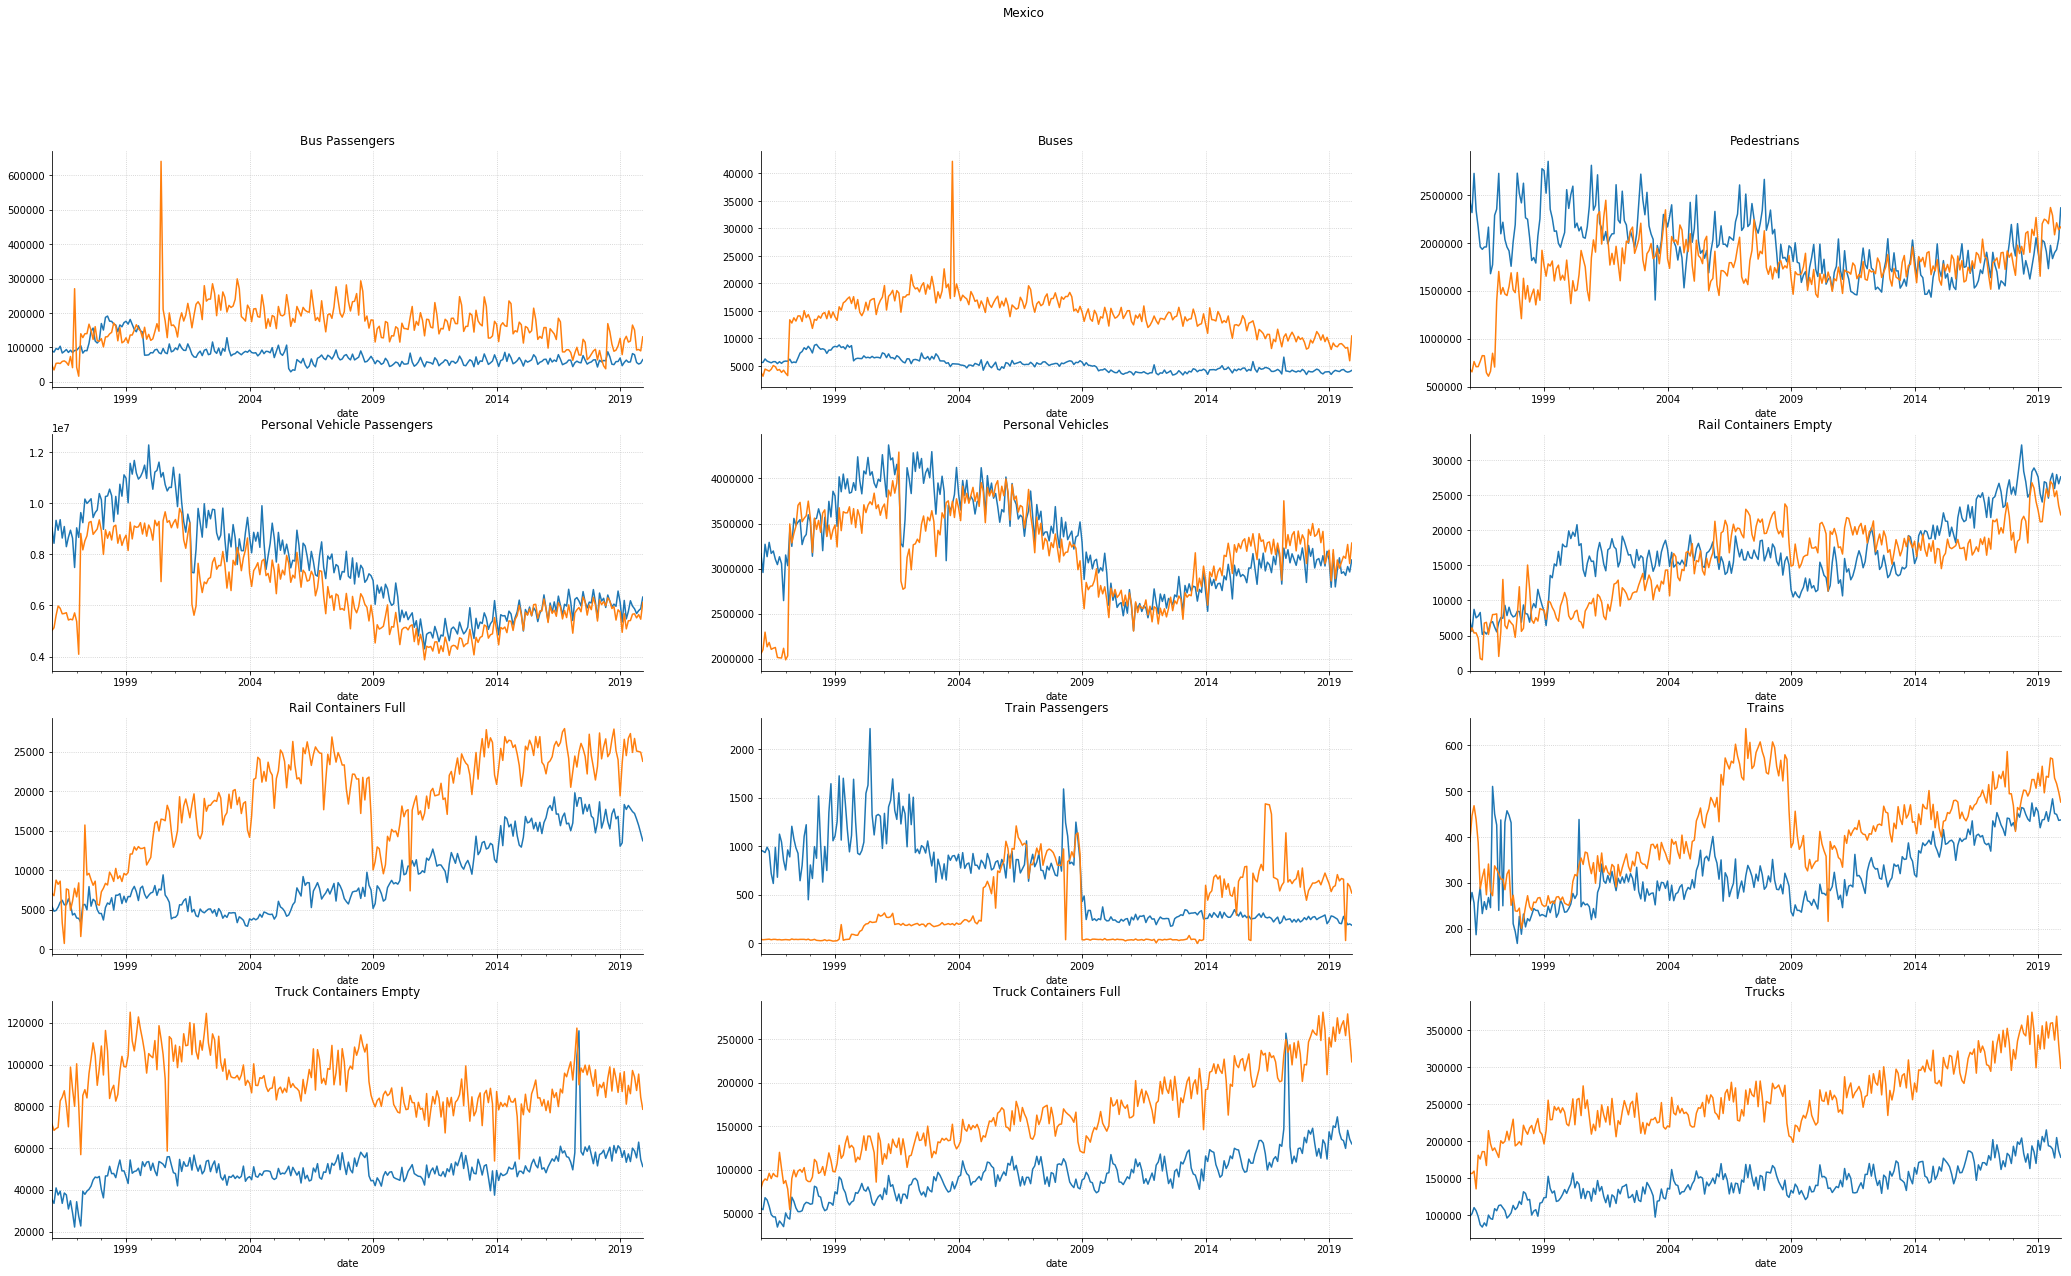

In [68]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))

fig.suptitle('Mexico')

for ax, (method, data) in zip(axs.ravel(), mexico.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'port_cluster', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()
#    ax.set_yscale('log')

In [69]:
from fbprophet import Prophet